In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [3]:
df = pd.read_csv('climate_change.csv')

In [5]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 24 #past 24 months (2 years)
future = 12 #next 12 months (1 year)
learning_rate = 0.001
batch_size = 256
epochs = 10

'''
Since every feature has values with varying ranges, we do normalization to confine feature values to a range of [0, 1] 
before training a neural network. 
We do this by subtracting the mean and dividing by the standard deviation of each feature.
'''
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [14]:
df.index = df['Date'] #set index
df = df.drop('Date',axis=1) #drop the column Date after setting the Date as index
features = normalize(df.values, train_split) #normalize data
features = pd.DataFrame(features) #save into df
features.head()

train_data = features.loc[0 : train_split - 1] #create the test
val_data = features.loc[train_split:]

In [19]:
start = past + future
end = start + train_split

#The training dataset labels starts from the 36nd observation (24 + 12)
x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

''''
takes in a sequence of data-points gathered at equal intervals, along with time series parameters, 
to produce batches of sub-timeseries inputs and targets sampled from the main timeseries
'''

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length, #length of the sequences/windows
    sampling_rate=step,
    batch_size=batch_size,
)

In [20]:
# Validation dataset 
'''
It must not contain the last 24 rows as we won't have label data for those records, hence 24 must be subtracted 
from the end of the data.
'''
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

In [21]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 4, 7)
Target shape: (256, 1)


In [22]:
# TRAINING
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 7)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5120      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [23]:
path_checkpoint = "model_checkpoint.h5"
# callback to interrupt training when the validation loss is not longer improving
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

# callback to regularly save checkpoints
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
2/2 [==============================] - 2s 374ms/step - loss: 0.9954 - val_loss: 0.8935

Epoch 00001: val_loss improved from inf to 0.89349, saving model to model_checkpoint.h5
Epoch 2/10
2/2 [==============================] - 0s 64ms/step - loss: 0.9872 - val_loss: 0.8582

Epoch 00002: val_loss improved from 0.89349 to 0.85818, saving model to model_checkpoint.h5
Epoch 3/10
2/2 [==============================] - 0s 78ms/step - loss: 0.9815 - val_loss: 0.8329

Epoch 00003: val_loss improved from 0.85818 to 0.83285, saving model to model_checkpoint.h5
Epoch 4/10
2/2 [==============================] - 0s 64ms/step - loss: 0.9766 - val_loss: 0.8188

Epoch 00004: val_loss improved from 0.83285 to 0.81880, saving model to model_checkpoint.h5
Epoch 5/10
2/2 [==============================] - 0s 64ms/step - loss: 0.9722 - val_loss: 0.8151

Epoch 00005: val_loss improved from 0.81880 to 0.81508, saving model to model_checkpoint.h5
Epoch 6/10
2/2 [==============================] - 0s 

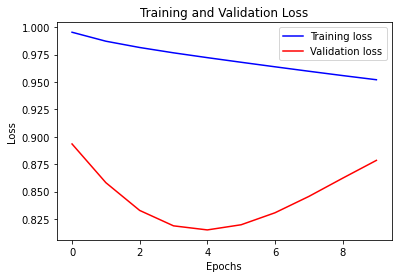

In [24]:
# Visualize the loss

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

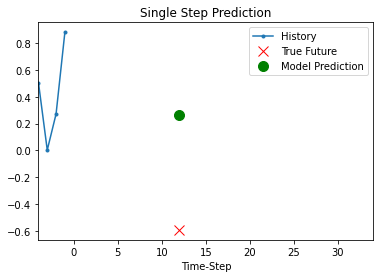

In [25]:
# PREDICTION

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",)